In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from matplotlib.ticker import LogFormatterSciNotation

sns.set_style('darkgrid')

In [42]:
path = r'..\data\20211209_viscosity_N1_raw_data.xlsx'
path_2 = r'..\data\20211115_Wierschem_low_shear_rate_measurements.xlsx'

In [43]:
df_all = pd.read_excel(path, header=0, skiprows=[1])
df_mpl = pd.read_excel(path, sheet_name='MPL', header=0, skiprows=[1])
df_wierschem = pd.read_excel(path, sheet_name='Wierschem', header=0, skiprows=[1])

df_low_shear = pd.read_excel(path_2, header=0)
df_mpl = df_mpl[df_mpl['Shear Rate'] > 90]
df_wierschem = df_wierschem[df_wierschem['Shear Rate'] > 9]

df_05_low_shear = df_low_shear[df_low_shear['Buffer']=='0.49% MC-PBS']
df_05_low_shear = df_05_low_shear[df_05_low_shear['Shear Rate'] < 20]
df_06_low_shear = df_low_shear[df_low_shear['Buffer']=='0.59% MC-PBS']
df_06_low_shear = df_06_low_shear[df_06_low_shear['Shear Rate'] < 30]
df_084_low_shear = df_low_shear[df_low_shear['Buffer']=='0.83% MC-PBS']
df_084_low_shear = df_084_low_shear[df_084_low_shear['Shear Rate'] < 100]

df_low_shear_all = pd.concat([df_05_low_shear,df_06_low_shear,df_084_low_shear])
concatenated = pd.concat([df_mpl.assign(Device='CP'), df_wierschem.assign(Device='PP'),
                          df_low_shear_all.assign(Device='CC - rotation')],
                         ignore_index=True)
concatenated

Meas. Pts.        Buffer  Shear Rate  Shear Stress  Viscosity        N1  \
0            10  0.49% MC-PBS     100.000      2.017300     20.173  0.004333   
1            11  0.49% MC-PBS     162.000      3.163300     19.545  0.011350   
2            12  0.49% MC-PBS     262.000      4.906300     18.727  0.029739   
3            13  0.49% MC-PBS     424.000      7.527000     17.749  0.077925   
4            14  0.49% MC-PBS     686.000     11.368000     16.560  0.204193   
..          ...           ...         ...           ...        ...       ...   
331          37  0.83% MC-PBS       0.251      0.022071     87.867       NaN   
332          38  0.83% MC-PBS       0.200      0.017244     86.427       NaN   
333          39  0.83% MC-PBS       0.158      0.013793     87.030       NaN   
334          40  0.83% MC-PBS       0.126      0.011087     88.071       NaN   
335          41  0.83% MC-PBS       0.100      0.008846     88.464       NaN   

     Repeat         Device  
0         1             CP  
1         1             CP  
2         1             CP  
3         1             CP  
4         1             CP  
..      ...            ...  
331       2  CC - rotation  
332       2  CC - rotation  
333       2  CC - rotation  
334       2  CC - rotation  
335       2  CC - rotation  

[336 rows x 8 columns]

In [44]:
df_05 = concatenated[concatenated['Buffer']=='0.49% MC-PBS']
df_06 = concatenated[concatenated['Buffer']=='0.59% MC-PBS']
df_084 = concatenated[concatenated['Buffer']=='0.83% MC-PBS']


In [45]:
groupby = concatenated.groupby(by=['Device', 'Buffer', 'Shear Rate'])

df_means = groupby.mean()
df_stds = groupby.std()

# sort the rows according to plot order in the scatter plot
plot_order = ['CC - rotation',
              'CP', 'PP']
df_means = df_means.loc[plot_order,:,:].reset_index()
df_stds = df_stds.loc[plot_order,:,:].reset_index()

In [47]:
def cy_model(x, vis_0, vis_inf, t, n, a):
    """Carreau Yasuda model for shear thinning fluid"""
    return vis_inf + (vis_0 - vis_inf) * (1 + (t*x)**a)**((n-1)/a)

def cy_model_vis_inf_fixed(x, vis_0, t, n, a):
    """Carreau Yasuda model for shear thinning fluid with infinite viscosity=0 """

    return vis_0 * (1 + (t*x)**a)**((n-1)/a)

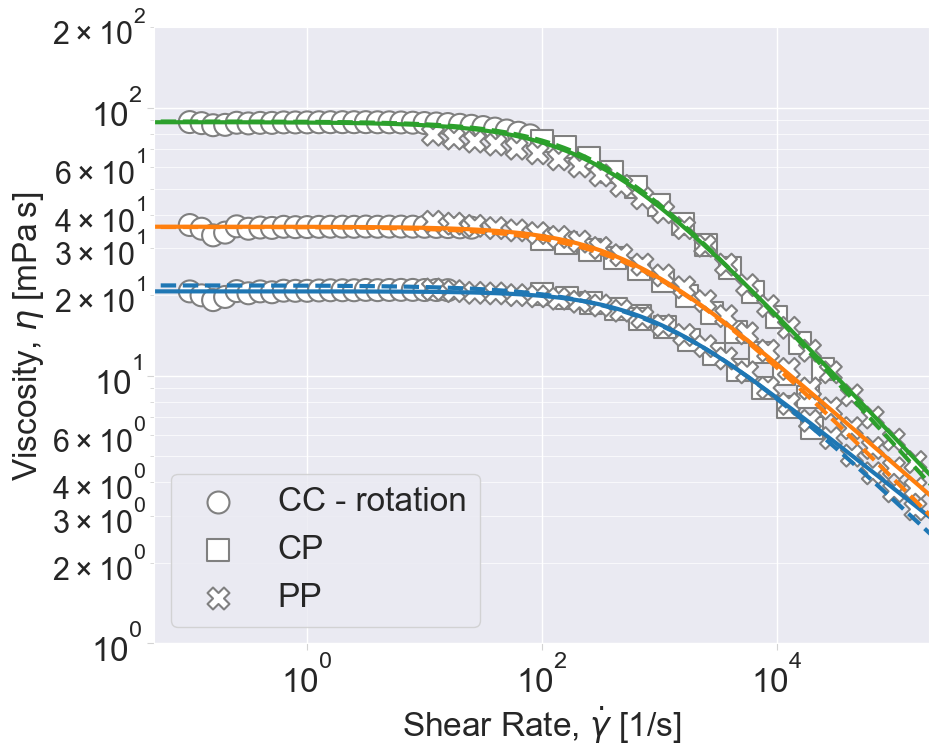

In [49]:
x_axis='Shear Rate'
y_axis='Viscosity'
plot_order = ['CC - rotation',
              'CP', 'PP']

fontsize = 24
concentrations = concatenated['Buffer'].unique()
colors = sns.color_palette('tab10', len(concentrations))

kws = {"s": 250, "linewidth": 1.5,
       "edgecolor": 'gray', "facecolor": "w"}

df_fit_params = pd.DataFrame()
df_fit_params_cp =pd.DataFrame()

with sns.axes_style('darkgrid'):
    fig = plt.figure(0, (10,8))
    ax = plt.subplot(111)

    sns.scatterplot(x=x_axis, y=y_axis, data=df_means,
                    #hue='Buffer', palette='tab10',
                    hue_order = plot_order,
                    style='Device',
                    style_order = plot_order,
                    markers=['o', 's', 'X'],
                    ax=ax,
                    **kws
                    )

    # perform carreau-yasuda fits
    for color, cc in zip(colors, concentrations):
        df_c = concatenated[concatenated['Buffer'] == cc]
        df_cp = df_mpl[df_mpl['Buffer']==cc]

        xdata = df_c['Shear Rate']
        ydata = df_c['Viscosity']
        xdata_cp = df_cp['Shear Rate']
        ydata_cp = df_cp['Viscosity']

        init_guess = [20, 1e-3, 0.6, 2] # initial guesses
        bounds=([0, 0, 0, 0], [np.inf,np.inf,1, np.inf]) #boundaries

        popt, pcov = curve_fit(cy_model_vis_inf_fixed, xdata, ydata,  maxfev=7000,  # fit with all data points
                               bounds=bounds,
                               p0=init_guess # initial guesses
                               )
        popt_cp, pcov_cp = curve_fit(cy_model_vis_inf_fixed, xdata_cp, ydata_cp,  maxfev=7000,  # fit with only CP data
                                     bounds=bounds,
                                     p0=init_guess # initial guesses
                                     )

        x_fit = np.logspace(-2,6, num=1000)
        ax.plot(x_fit, cy_model_vis_inf_fixed(x_fit, *popt), ls='-', color=color,
                lw=3,
                label='CY model-all data')
        ax.plot(x_fit, cy_model_vis_inf_fixed(x_fit, *popt_cp), ls='--', color=color,
                lw=3,
                label='CY model-only CP data')

        #print("{}, zero_viscosity={}".format(cc, popt[0]))
        fit_params = {'zero_viscosity': [popt[0]],
                      'zero_viscosity_err': [np.sqrt(np.diag(pcov)[0])],
                      'concentration': [cc],
                      'characteristic time': [popt[1]],
                      'char_time_err': [np.sqrt(np.diag(pcov)[1])],
                      'n': [popt[2]],
                      'n_err': [np.sqrt(np.diag(pcov)[2])],
                      'a': [popt[3]],
                      'a_err': [np.sqrt(np.diag(pcov)[3])]
                      }
        df_fit_params = pd.concat([df_fit_params, pd.DataFrame(fit_params)])

        fit_params_cp = {'zero_viscosity': [popt_cp[0]],
                         'zero_viscosity_err': [np.sqrt(np.diag(pcov_cp)[0])],
                         'concentration': [cc],
                         'characteristic time': [popt_cp[1]],
                         'char_time_err': [np.sqrt(np.diag(pcov_cp)[1])],
                         'n': [popt_cp[2]],
                         'n_err': [np.sqrt(np.diag(pcov_cp)[2])],
                         'a': [popt_cp[3]],
                         'a_err': [np.sqrt(np.diag(pcov_cp)[3])]
                         }
        df_fit_params_cp = pd.concat([df_fit_params_cp, pd.DataFrame(fit_params_cp)])

    ax.set(xscale='log', yscale='log')
    ax.set_xlim(0.05, 2e5)
    ax.set_ylim(1, 200)

    ax.tick_params(reset=True, axis='both', which='major', labelsize=fontsize, length=5,
                   top=False, right=False, color='lightgray')
    ax.tick_params(reset=True, axis='both', which='minor', labelsize=fontsize-2, length=3,
                   top=False, right=False, color='lightgray')

    ax.grid(visible=True, which='minor', axis='both', linewidth=0.5)
    ax.grid(visible=True, which='major', axis='both', linewidth=1)

    y_minor_formatter = LogFormatterSciNotation(base=10, labelOnlyBase=False, minor_thresholds=[3,0])
    ax.yaxis.set_minor_formatter(y_minor_formatter)

    plt.xlabel("Shear Rate, $\dot\gamma$ [1/s]", fontsize=fontsize)
    plt.ylabel("Viscosity, $\eta$ [mPa$\,$s]", fontsize=fontsize)

    # default legend markers are different than actual plot markers
    # create custom markers
    o_handle = plt.scatter([], [], marker='o', **kws, label='circle')
    #tri_handle = plt.scatter([], [], marker='^', **kws, label='triangle')
    square_handle = plt.scatter([], [], marker='s', **kws, label='square')
    x_handle = plt.scatter([], [], marker='X', **kws, label='X')
    #b_1_handle = plt.scatter([], [], marker=None, color='tab:blue')
    #b_2_handle = plt.scatter([], [], marker=None, color='tab:orange')
    #b_3_handle = plt.scatter([], [], marker=None, color='tab:green')
    #lines = ax.lines

    handles = [o_handle, square_handle, x_handle]
    labels = ['CC - rotation', 'CP', 'PP']

    # change color of the line handles to black
    # one legend marker for all three fit lines
    ax.legend(handles, labels, loc='best', ncol=1, fontsize=24)
    leg = ax.get_legend()

    fig.patch.set_alpha(0)
    savename = r"..\plots\graphical_abstract_plots\plot_1"
    fig.savefig(savename+".png", dpi=900, bbox_inches="tight")
    fig.savefig(savename+".pdf", dpi=900, bbox_inches="tight")

    plt.show()

In [50]:
concatenated_N1 = pd.concat([df_mpl.assign(Device='CP'), df_wierschem.assign(Device='PP')])
groupby_N1 = concatenated_N1.groupby(by=['Device', 'Buffer', 'Shear Rate'])#, as_index=False)

df_means_N1 = groupby_N1.mean()
df_stds_N1 = groupby_N1.std()
df_cp_means_filt = df_means[df_means['Device']=='PP']
df_cp_means_filt

Device        Buffer  Shear Rate  Meas. Pts.  Shear Stress  Viscosity  \
116     PP  0.49% MC-PBS        11.8         7.0         0.247      21.00   
117     PP  0.49% MC-PBS        17.8         8.0         0.368      20.70   
118     PP  0.49% MC-PBS        26.8         9.0         0.548      20.40   
119     PP  0.49% MC-PBS        40.4        10.0         0.818      20.30   
120     PP  0.49% MC-PBS        60.9        11.0         1.220      20.00   
..     ...           ...         ...         ...           ...        ...   
183     PP  0.83% MC-PBS     28900.0        26.0       296.000      10.30   
184     PP  0.83% MC-PBS     43600.0        27.0       368.000       8.45   
185     PP  0.83% MC-PBS     65800.0        28.0       459.000       6.98   
186     PP  0.83% MC-PBS     99500.0        29.0       574.000       5.77   
187     PP  0.83% MC-PBS    152000.0        30.0       723.000       4.76   

              N1  Repeat  
116          NaN     1.0  
117          NaN     1.0  
118          NaN     1.0  
119          NaN     1.0  
120          NaN     1.0  
..           ...     ...  
183   766.427835     1.0  
184   997.727631     1.0  
185  1271.440757     1.0  
186  1626.307814     1.0  
187  2105.480600     1.0  

[72 rows x 8 columns]

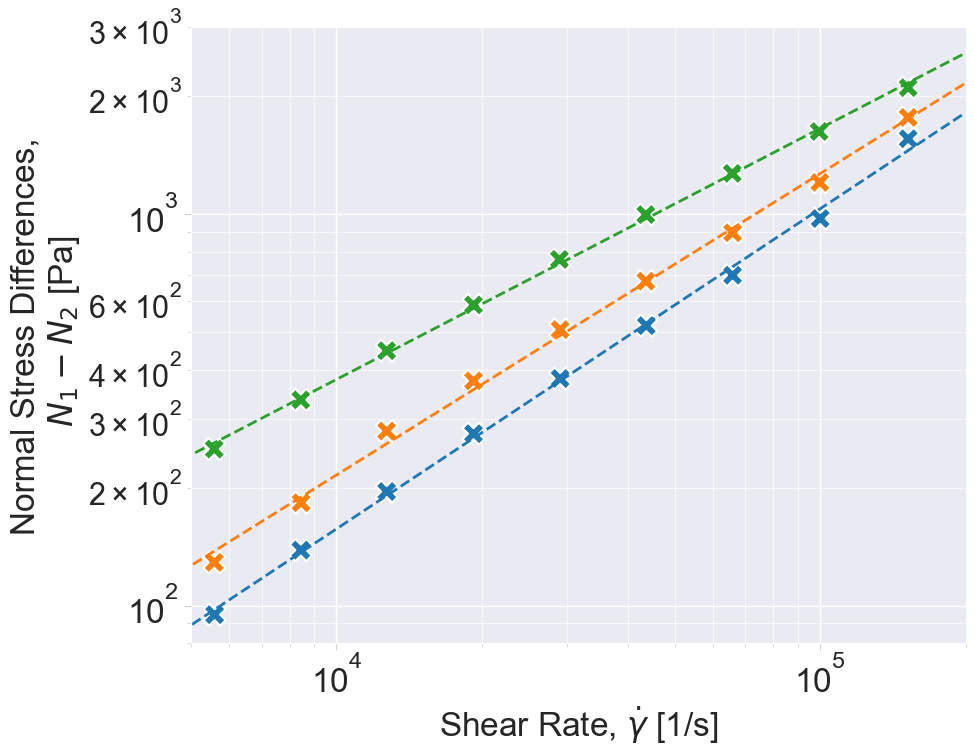

In [51]:
x_axis='Shear Rate'
y_axis='N1'
#plot_order = ['CC - rotation', 'CC - oscillation', 'CP', 'PP']

fontsize = 24
concentrations = concatenated_N1['Buffer'].unique()
colors = sns.color_palette('tab10', len(concentrations))

kws = {"s": 250, "linewidth": 1.5}  #, 'alpha': 0.5
kws_2 = {"s": 250, "linewidth": 1.5,
         "edgecolor": 'gray', "facecolor": "w"}

df_fit_params_n1_cp = pd.DataFrame()


with sns.axes_style('darkgrid'):
    fig = plt.figure(0, (10,8))
    ax = plt.subplot(111)

    sns.scatterplot(x=x_axis, y=y_axis, data=df_cp_means_filt,
                    hue='Buffer',
                    palette='tab10',
                    #hue_order = plot_order,
                    #style='Device',
                    #style_order = plot_order,
                    marker='X',
                    ax=ax,
                    **kws
                    )
    # Fitting the N1 data to Power Law

    for color, cc in zip(colors, concentrations):
        data_cp = df_cp_means_filt[df_cp_means_filt['Buffer'] == cc]


        shear_rate_cp_filt = data_cp['Shear Rate'] >= 5000 # power law regime


        powerlaw_regime_cp = data_cp[shear_rate_cp_filt]


        xdata_cp = np.array(powerlaw_regime_cp['Shear Rate'], dtype=float)
        #   ydata = np.array(powerlaw_regime['Viscosity'], dtype=float)  # viscosity fitting (if needed)
        ydata_cp = np.array(powerlaw_regime_cp['N1'], dtype=float)


        log_xdata_cp = np.log(xdata_cp)
        log_ydata_cp = np.log(ydata_cp)


        fit_n1_cp, cov_n1_cp = np.polyfit(log_xdata_cp, log_ydata_cp, 1, cov=True)


        n_n1_cp = fit_n1_cp[0]
        K_n1_cp = np.exp(fit_n1_cp[1])
        n_n1_cp_err = np.sqrt(np.diag(cov_n1_cp)[0])
        K_n1_cp_err = np.sqrt(np.diag(cov_n1_cp)[1])

        xdata_fit = np.logspace(3.6,5.3)
        ydata_cp_fit =  K_n1_cp * xdata_fit**n_n1_cp

        ax.plot(xdata_fit, ydata_cp_fit, ls='--', color=color,
                lw=2,
                label='CP-power law fit')

        fit_params_n1_cp = {'n_n1_cp': [n_n1_cp],
                            'K_n1_cp': [K_n1_cp],
                            'Buffer' : [cc],
                            'n_n1_pp_err' : [n_n1_cp_err],
                            'K_n1_cp_err' : [K_n1_cp_err * K_n1_cp]
                            }
        df_fit_params_n1_cp = pd.concat([df_fit_params_n1_cp, pd.DataFrame(fit_params_n1_cp)])  #df_fit_params_n1_cp.append(fit_params_n1_cp, ignore_index=True)

    ax.set(xscale='log', yscale='log')
    ax.set_xlim(5000, 2e5)
    ax.set_ylim(80, 3000)

    ax.tick_params(reset=True, axis='both', which='major', labelsize=fontsize, length=5,
                   top=False, right=False, color='lightgray')
    ax.tick_params(reset=True, axis='both', which='minor', labelsize=fontsize-2, length=3,
                   top=False, right=False, color='lightgray')

    ax.grid(visible=True, which='minor', axis='both', linewidth=0.5)
    ax.grid(visible=True, which='major', axis='both', linewidth=1)

    y_minor_formatter = LogFormatterSciNotation(base=10, labelOnlyBase=False, minor_thresholds=[3,0])
    ax.yaxis.set_minor_formatter(y_minor_formatter)

    plt.xlabel("Shear Rate, $\dot\gamma$ [1/s]", fontsize=fontsize)
    plt.ylabel("Normal Stress Differences,\n $N_1 - N_2$ [Pa]", fontsize=fontsize)

    square_handle = plt.scatter([], [], marker='s', **kws_2, label='square')
    b_1_handle = plt.scatter([], [], marker=None, color='tab:blue')
    b_2_handle = plt.scatter([], [], marker=None, color='tab:orange')
    b_3_handle = plt.scatter([], [], marker=None, color='tab:green')

    lines = ax.lines

    handles = [ square_handle, b_1_handle, b_2_handle, b_3_handle] + lines[:1]
    labels = ['CP - $N_1$', '0.49% MC-PBS', '0.59% MC-PBS', '0.83% MC-PBS','CP-power law fit']

    # change color of the line handles to black
    # one legend marker for all three fit lines
    # ax.legend(handles, labels, loc='lower left', fontsize=24, bbox_to_anchor=[.75,0])
    # leg = ax.get_legend()
    # leg.legendHandles[-1].set_color('k')
    ax.legend_ = None
    fig.patch.set_alpha(0)
    savename = r"..\plots\graphical_abstract_plots\plot_2"
    fig.savefig(savename+".png", dpi=900, bbox_inches="tight")
    fig.savefig(savename+".pdf", dpi=900, bbox_inches="tight")

    plt.show()